<a href="https://colab.research.google.com/github/armenbod/ocf_coding_challenge/blob/main/cif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Carbon Intensity of the National Grid

### OCF Coding Challenge
Armen Bodossian </br>
06/12/2023

##  Table of Contents

* [Initialisation](#Initialisation)
* [Read Data](#Read-Data)
* [Feature Creation](#Feature-Creating)
* [Modelling](#Modelling)
* [Evaluation](#Evaluation)
* [Next Steps](#Next-Steps)


## Initialisation

### Installing Modules from requirements file

In [ ]:
! pip install -r ./requirements.txt

### Importing modules



In [2]:
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape

# Modelling
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner
import pytorch_forecasting as ptf
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import TorchNormalizer
from pytorch_forecasting.metrics import MAE, MAPE

# Plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Additional Datasets
import holidays

### Defining Parameters

In [3]:
data_path = './data/'
model_path = './model/'
filename = 'carbon_intensity_demand_solar_wind_2022-01-01_2023-01-01.csv'

## Read Data

In [4]:
# Read data and output first rows

data_raw = pd.read_csv(f'{data_path}{filename}')
data_raw["from"] = pd.to_datetime(data_raw["from"])
data_raw.head()

from  carbon_intensity_actual  \
0 2022-01-01 00:00:00+00:00                     74.0   
1 2022-01-01 00:30:00+00:00                     75.0   
2 2022-01-01 01:00:00+00:00                     73.0   
3 2022-01-01 01:30:00+00:00                     68.0   
4 2022-01-01 02:00:00+00:00                     71.0   

   carbon_intensity_forecast  demand  "Solar"  "Wind Offshore"  "Wind Onshore"  
0                         74   21690      0.0         6480.583        4739.050  
1                         70   21830      0.0         6480.583        4739.050  
2                         70   21335      0.0         6708.648        5380.218  
3                         61   20239      0.0         6708.648        5380.218  
4                         62   19224      0.0         6978.515        6059.516

In [5]:
# Define ts column
ts_col = "from"

In [6]:
# plot the data to inspect each feature

fig = make_subplots(rows=3, cols=2, start_cell="top-left")

fig.add_trace(go.Scatter(x=data_raw["from"], y=data_raw['carbon_intensity_actual'], name='carbon_intensity_actual'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=data_raw["from"], y=data_raw['carbon_intensity_forecast'], name='carbon_intensity_forecast'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=data_raw["from"], y=data_raw['demand'], name='demand'),
              row=2, col=1)
fig.add_trace(go.Scatter(x=data_raw["from"], y=data_raw['"Solar"'], name='solar_forecast'),
              row=2, col=2)
fig.add_trace(go.Scatter(x=data_raw["from"], y=data_raw['"Wind Offshore"'], name='offshore_wind_forecast'),
              row=3, col=1)
fig.add_trace(go.Scatter(x=data_raw["from"], y=data_raw['"Wind Onshore"'], name='onshore_wind_forecast'),
              row=3, col=2)

fig.update_layout(height=1000, width=1200, title_text="Time series plots")

fig.show()

In [7]:
# Find null data

cols_with_nulls = []
for cols in data_raw.columns:
    null_rows = len(data_raw.loc[data_raw[cols].isna()])
    if null_rows > 0:
      print(f'Number of nulls for column {cols}: {null_rows}')
      cols_with_nulls.append(cols)

Number of nulls for column carbon_intensity_actual: 51
Number of nulls for column "Solar": 288
Number of nulls for column "Wind Offshore": 288
Number of nulls for column "Wind Onshore": 288


* Evidently have seasonality patterns in demand data caused by daily, and annual patterns - need to create features for these. For example, demand increases during the daylight hours, whilst solar generation is dependent on time of year
* Additionally worth including holiday days e.g. christmas time where demand patterns can be affected
* If easy to find a crude weather forecast related dataset representative of UK can also be useful (if we have time)

## Feature Creation

In [8]:
data = data_raw.copy()
data['time_idx'] = data.index
data['month'] = data[ts_col].dt.month
data['dayofweek'] = data[ts_col].dt.dayofweek
data['hour'] = data[ts_col].dt.hour
data['group'] = 0

# Impute missing values
for cols in cols_with_nulls:
    data[cols] = data[cols].interpolate(method='linear', order=2)

# Remove forecasted carbon intensity from our training ds
data = data.drop(columns=['carbon_intensity_forecast', 'from'])

# Define target as column to predict
target = 'carbon_intensity_actual'

In [9]:
# If we had more time we could also experiment with including exogenous variables to further provide info to the model, including British holidays using the dataset below:

# uk_holidays_dict = holidays.UK(years=[2022])
# uk_holidays = pd.DataFrame(data={'from' : uk_holidays_dict.keys(),
#                                  'holiday' : uk_holidays_dict.values(),
#                                  'is_holiday' : [1] * len(uk_holidays_dict)}
# )
# uk_holidays.head()

## Modelling

Modelling is done using the [DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) Model, which is good for forecasting 1-D time series models and makes use of recurrent neural nets. As a result it is able to capture non-linear relationships including seasonality.

The dataset is transformed using parameters that are taken into the model training:

* `prediction_length` : Length of prediction. In this case we pick 48, to producte a 24 hour prediction of half-hourly data
* `context_length` : The size of the window used to predict the next day. This can be tuned based on sensible windows which account for the data's pattern (e.g. seasonalities). A sensible pass would be to use 4-12 weeks
* `rnn_layers` : Number of recurrent networks in DeepAR architecture. Increasing can improve model understanding of complex relationships (although can increase risk of overfitting / increases train time)
* `hidden_size` : Size of recurrent layer. Increasing has same benefits and downsides as `rnn_layers`.

From generating the time series dataset that is usable for torch, we build our train and validation dataset.


In [22]:
max_encoder_length = 48 * 7 * 4
max_prediction_length = 48

rnn_layers = 2
hidden_size = 40

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

# create dataset and dataloaders
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["group"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    time_varying_unknown_reals=[target],
    target_normalizer=TorchNormalizer(method='identity', center=True, transformation=None, method_kwargs={}),
    add_target_scales=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128

train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0
)

To start with a baseline prediction is created, which uses the last known value to make the prediction. The MAPE and MAE values are provided.

In [23]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)

b_smape = MAPE()(baseline_predictions.output, baseline_predictions.y).numpy()
b_mae = MAE()(baseline_predictions.output, baseline_predictions.y).numpy()

print(f'Baseline model: MAPE = {b_smape:.3f}, MAE = {b_mae:.3f}')

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:li

Baseline model: MAPE = 0.321, MAE = 42.896


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:187: PossibleUserWarning:

GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.



In [24]:
pl.seed_everything(42)

trainer = pl.Trainer(accelerator="gpu", gradient_clip_val=1e-1,)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=hidden_size,
    rnn_layers=rnn_layers,
    optimizer="Adam",
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Find optimal learning rate using PyTorch tuner


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/utilities.py:73: PossibleUserWarning:

`max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.0033113112148259105
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0033113112148259105
INFO: Restoring states from the checkpoint path at /content/.lr_find_224a3a90-a3e3-4394-802e-6bf8866839ce.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_224a3a90-a3e3-4394-802e-6bf8866839ce.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_224a3a90-a3e3-4394-802e-6bf8866839ce.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_224a3a90-a3e3-4394-802e-6bf8866839ce.ckpt


Suggested learning rate: 0.0033113112148259105


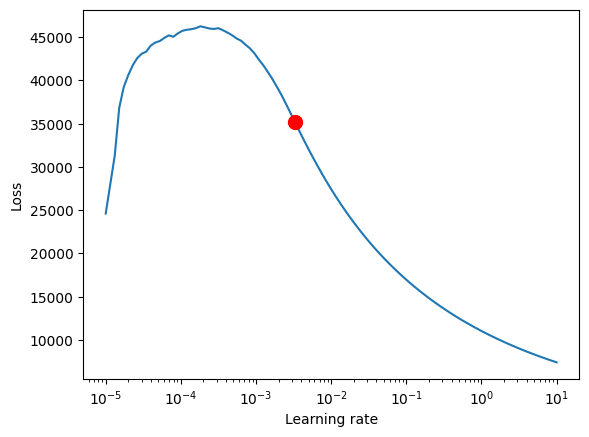

In [25]:
res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e1,
    early_stop_threshold=100,
)

print(f"Suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

### Train model

In [45]:
# Define model parameters

lr = 0.003
max_epochs = 100

In [46]:
# Define early-stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

# Generate trainer object
trainer = pl.Trainer(
    max_epochs=max_epochs,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=200,
    enable_checkpointing=True,
)


# Define the network
net = DeepAR.from_dataset(
    training,
    learning_rate=lr,
    log_interval=10,
    log_val_interval=1,
    hidden_size=hidden_size,
    rnn_layers=rnn_layers,
    optimizer="Adam",
)

# Start training process, including validation set
trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Evaluation

In [52]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: UserWarning:

Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:198: UserWarning:

Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.



In [53]:
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)

p_mape = MAPE()(predictions.output, predictions.y).numpy()
p_mae = MAE()(predictions.output, predictions.y).numpy()

print(f'DeepAR model: MAPE = {p_mape:.3f}, MAE = {p_mae:.3f}')

INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:187: PossibleUserWarning:

GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve p

DeepAR model: MAPE = 0.248, MAE = 27.173


In [54]:
# Comparing with stats from existing forecast

e_mape = mape(data_raw['carbon_intensity_forecast'][-48:], data_raw['carbon_intensity_actual'][-48:])
e_mae = mae(data_raw['carbon_intensity_forecast'][-48:], data_raw['carbon_intensity_actual'][-48:])

print(f'Existing forecast: SMAPE = {e_mape:.3f}, MAE = {e_mae:.3f}')

Existing forecast: SMAPE = 0.067, MAE = 7.021


It appears that we are still some way off the existing forecast

In [55]:
# Plot all together
trace1 = go.Scatter(x=data_raw["from"][-48:], y=predictions.output.cpu().numpy()[0], mode='lines', name='DeepAR Prediction')
trace2 = go.Scatter(x=data_raw["from"][-192:], y=data_raw['carbon_intensity_actual'][-192:], name='carbon_intensity_actual')
trace3 = go.Scatter(x=data_raw["from"][-192:], y=data_raw['carbon_intensity_forecast'][-192:], name='carbon_intensity_forecast')

layout = go.Layout(title='Predictive model vs Existing forecast / Actuals')

# Create the figure and add traces
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

### Export model

In [56]:
! cp '{best_model_path}' ./model/

## Next Steps

The following should certainly be explored if more time is allowed to improve the results of the model:

* **Training model for further epochs**: The model still appears to be converging on a solution and therefore more epochs may help improve the result. Using the `early_stop_callback` will help to reduce risk of overfitting
* **Creating an experiment matrix for testing different hyperparameters**: Editing the size of layers, depth, and testing different context lengths may find a better solution
* **Adding complementary datasets**: Exogenous variables like holidays previously discussed, using weather API would also be very important (e.g. temperature vs requirement to heat homes). Some further analysis can be done to find statistical relationships between features and target (ensuring that non-linear relationships be explored)
* **Input existing forecast as a validation metric during training**
* **Trying other model types / architectures**: Though DeepAR is an industry-standard, it may be worth looking at similar (e.g. TFTs, Wavenet for time-series), or indeed, less complex regressive models (SARIMAX, FBProphet) and evaluating best fit. The bias to pick a deep-learning model is the ability to model non-linear behaviours and also for architectures that have a 'memory' / 'attention' element to them such as recurrent nets, or transfomers.